In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.figure_factory as ff
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

SEED = 42

In [2]:
projects = pd.read_csv("../data/nrao_projects.csv")
projects = projects.set_index('project_code')

In [3]:
line_projects = projects.query('fs_type == "line"')
line_projects.shape

(3628, 12)

In [4]:
measurements = pd.read_csv('../../nrao_measurements.csv')
measurements = measurements.set_index('project_code')
measurements = measurements[measurements.fs_type == 'line']

## Remove outliers from projects and measurements

See 'Identifying_High_Measurement_Projects.ipynb' in 'data' folder

From this notebook, any project with > 26.5 measurements is an outlier

In [5]:
project_measurements = measurements.groupby(measurements.index)\
    .project_title.count()\
        .sort_values(ascending=False)\
        .to_frame()
project_measurements.columns = ['measurement_count']
project_measurements.head()

,measurement_count
project_code,
2017.1.00161.L,289
2017.1.00886.L,283
2021.2.00052.S,265
2023.1.00963.S,253
2022.1.00224.S,188


In [6]:
outliers = project_measurements[project_measurements.measurement_count > 26.5]

In [7]:
measurements = measurements.loc[~measurements.index.isin(outliers.index)]
line_projects = line_projects.loc[~line_projects.index.isin(outliers.index)]

## Train-test split

In [8]:
train_texts, test_texts = train_test_split(line_projects.lemmatized_no_sw_text, random_state=SEED)

In [9]:
print(f'Number of train texts:{len(list(train_texts))}')
print(f'Number of test texts:{len(list(test_texts))}')

Number of train texts:2463
Number of test texts:821


In [10]:
train_texts

project_code
2016.1.00187.S    magnetic field high mass star formation propos...
2013.1.00883.S    hd pristine gas evolve dust transition proto p...
2021.1.00424.S    core brown dwarfs unraveling substellar format...
2013.1.00988.S    understand agn feedback gas chemistry ngc ngc ...
2017.1.00575.S    measure line width rrl blr circinus galaxy pro...
                                        ...                        
2022.1.00453.S    search volatile phosphorus epoch planet format...
2015.1.00453.S    hcn hnc fundamental problem astrophysics two i...
2021.1.01126.S    unveiling nature peculiar embed icy object dis...
2013.1.00328.S    detailed view bird anatomy vital organ rare tr...
2018.A.00063.S    localize feedback process galactic cmz feedbac...
Name: lemmatized_no_sw_text, Length: 2463, dtype: object

### LDA class

In [11]:
class LDA_Model:
    def __init__(self, N_topics=3):
        self.N_topics = N_topics
        self.countVectorizer = CountVectorizer(stop_words='english')
        self.lda = LatentDirichletAllocation(n_components=self.N_topics, random_state=SEED)
    
    def fit(self, corpus):
        termFrequency = self.countVectorizer.fit_transform(corpus)
        self.lda.fit(termFrequency)
        return self.lda.transform(termFrequency)

    # Additional method to transform new data
    def transform(self, corpus):
        termFrequency = self.countVectorizer.transform(corpus)
        return self.lda.transform(termFrequency)

#### Initialize Model

In [12]:
lda_model = LDA_Model(N_topics=50)

#### Fit model on training set

In [13]:
train_topics = lda_model.fit(train_texts)

In [14]:
words = lda_model.countVectorizer.get_feature_names_out()

In [15]:
N = 10 #number of top words to show
topic_components = lda_model.lda.components_

for topic_idx, topic in enumerate(topic_components):
    print(f"Topic {topic_idx}:")
    # Get the indices of the top N words for this topic
    top_word_indices = topic.argsort()[-N:][::-1]
    # Print these words with their weights
    for word_idx in top_word_indices:
        print(f"{words[word_idx]} (weight: {topic[word_idx]:.2f})")
    print("\n")

Topic 0:
grain (weight: 65.51)
disk (weight: 58.59)
dust (weight: 56.38)
observation (weight: 37.19)
growth (weight: 30.22)
propose (weight: 29.70)
streamer (weight: 27.07)
mass (weight: 25.76)
measure (weight: 22.12)
model (weight: 21.69)


Topic 1:
carbon (weight: 82.55)
pdr (weight: 79.47)
line (weight: 71.43)
model (weight: 59.21)
chemical (weight: 49.19)
uv (weight: 48.86)
abundance (weight: 45.20)
molecule (weight: 41.25)
region (weight: 40.93)
observe (weight: 36.16)


Topic 2:
infall (weight: 114.09)
field (weight: 37.60)
region (weight: 32.43)
magnetic (weight: 28.72)
aca (weight: 25.54)
map (weight: 22.72)
environment (weight: 20.48)
study (weight: 20.05)
observation (weight: 16.83)
faraday (weight: 16.31)


Topic 3:
star (weight: 311.81)
formation (weight: 164.01)
disk (weight: 110.04)
high (weight: 91.08)
angular (weight: 87.76)
scale (weight: 83.37)
massive (weight: 82.37)
accretion (weight: 73.43)
form (weight: 72.84)
observation (weight: 68.20)


Topic 4:
emission (weigh

In [16]:
train_doc_topic = pd.DataFrame(train_topics)
train_doc_topic = train_doc_topic.set_index(train_texts.index.values)
train_doc_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2016.1.00187.S,0.000175,0.000175,0.051596,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,...,0.000175,0.000175,0.476002,0.000175,0.000175,0.130695,0.000175,0.000175,0.000175,0.000175
2013.1.00883.S,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,...,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198
2021.1.00424.S,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,...,0.000183,0.000183,0.000183,0.876168,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183
2013.1.00988.S,0.000230,0.000230,0.000230,0.000230,0.000230,0.112832,0.000230,0.000230,0.000230,0.000230,...,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230
2017.1.00575.S,0.000290,0.000290,0.000290,0.000290,0.000290,0.020682,0.000290,0.000290,0.000290,0.000290,...,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290


In [17]:
train_texts = pd.DataFrame(train_texts)

### Match test data into topics

In [18]:
test_topics = lda_model.transform(test_texts)

In [19]:
test_doc_topic= pd.DataFrame(test_topics.tolist())
test_doc_topic= test_doc_topic.set_index(test_texts.index.values)
test_doc_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2017.1.00822.S,0.000204,0.000204,0.000204,0.000204,0.000204,0.625789,0.000204,0.038601,0.000204,0.000204,...,0.000204,0.000204,0.000204,0.000204,0.000204,0.000204,0.000204,0.000204,0.000204,0.000204
2011.0.00629.S,0.000177,0.122896,0.000177,0.000177,0.000177,0.000177,0.000177,0.000177,0.000177,0.000177,...,0.000177,0.000177,0.000177,0.131309,0.000177,0.000177,0.000177,0.000177,0.000177,0.114039
2016.1.01015.S,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,...,0.050184,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225
2016.1.01206.S,0.000247,0.000247,0.000247,0.000247,0.000247,0.000247,0.376084,0.000247,0.000247,0.000247,...,0.064222,0.000247,0.000247,0.000247,0.073479,0.000247,0.000247,0.000247,0.000247,0.000247
2016.1.00650.S,0.000177,0.000177,0.000177,0.000177,0.015123,0.149642,0.000177,0.000177,0.000177,0.263467,...,0.000177,0.000177,0.000177,0.000177,0.000177,0.151149,0.000177,0.000177,0.000177,0.000177


In [20]:
test_texts = pd.DataFrame(test_texts)

### Group documents to highest matching topic

Combine project topic vector frames

In [21]:
proj_topics = pd.concat([train_doc_topic, test_doc_topic])
proj_topics

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2016.1.00187.S,0.000175,0.000175,0.051596,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,0.000175,...,0.000175,0.000175,0.476002,0.000175,0.000175,0.130695,0.000175,0.000175,0.000175,0.000175
2013.1.00883.S,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,...,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198
2021.1.00424.S,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,...,0.000183,0.000183,0.000183,0.876168,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183
2013.1.00988.S,0.000230,0.000230,0.000230,0.000230,0.000230,0.112832,0.000230,0.000230,0.000230,0.000230,...,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230
2017.1.00575.S,0.000290,0.000290,0.000290,0.000290,0.000290,0.020682,0.000290,0.000290,0.000290,0.000290,...,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290,0.000290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017.1.01108.S,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,...,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208
2022.1.00873.V,0.000190,0.000190,0.000190,0.000190,0.095013,0.000190,0.000190,0.480779,0.000190,0.000190,...,0.000190,0.000190,0.000190,0.084450,0.000190,0.000190,0.000190,0.000190,0.000190,0.000190
2023.1.00717.S,0.000180,0.120219,0.000180,0.093377,0.000180,0.000180,0.000180,0.000180,0.000180,0.068492,...,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180
2023.1.01276.S,0.000198,0.000198,0.000198,0.159681,0.000198,0.121163,0.000198,0.000198,0.000198,0.000198,...,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198


Take highest matching topic for each project

In [22]:
proj_topics['max_topic'] = proj_topics.apply(lambda x: x.argmax(), axis=1)

Create data frame with project id and max topic

In [23]:
proj_max_topic = proj_topics['max_topic'].to_frame()
proj_max_topic

,max_topic
2016.1.00187.S,42
2013.1.00883.S,20
2021.1.00424.S,43
2013.1.00988.S,30
2017.1.00575.S,31
...,...
2017.1.01108.S,34
2022.1.00873.V,7
2023.1.00717.S,31
2023.1.01276.S,20


### Add `max_topic` to `measurements` frame to be able to group measurements by max topic

In [24]:
measurements = pd.merge(measurements, proj_max_topic, left_index=True, right_index=True)

In [25]:
proj_max_topic.value_counts().describe()

count     50.000000
mean      65.680000
std       94.162352
min        5.000000
25%       17.500000
50%       35.500000
75%       84.000000
max      527.000000
Name: count, dtype: float64

There are a few topics that match to a large number of documents. Perhaps we need a better topic model or to group documents by project_topic vector similarity.

Eyeball comparison of documents by max topic. This requires looking at the online explorer since printing out abstracts in here gets messy.

In [26]:
proj_max_topic[proj_max_topic.max_topic == 3].head()

,max_topic
2022.1.00383.S,3
2016.1.01367.S,3
2015.1.00320.S,3
2015.1.01596.S,3
2018.1.01740.S,3


### Generate test projects measurements
This will be useful for calculating hit rates to evaluate model performance.

**NOTE!!!**
You should not sort these, however tempting. We need to preserve the relationships of the entries to not lose measurement information.

In [27]:
test_proj_meas = measurements.loc[test_texts.index]
test_proj_meas = test_proj_meas.groupby(test_proj_meas.index)\
    .agg({
        'low_freq': lambda x: round(x, 4).tolist(),
        'high_freq': lambda x: round(x, 4).tolist(),
        'med_freq': lambda x: round(x, 4).tolist(),
        'diff_freq': lambda x: round(x, 4).tolist()
    })
test_proj_meas.head()

,low_freq,high_freq,med_freq,diff_freq
project_code,,,,
2011.0.00017.S,"[87.72, 89.54, 99.72, 101.54, 91.37, 93.19, 10...","[89.6, 91.42, 101.59, 103.42, 93.24, 95.07, 10...","[88.66, 90.48, 100.655, 102.48, 92.305, 94.13,...","[1.88, 1.88, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8..."
2011.0.00028.S,"[342.36, 344.24, 354.28, 355.79, 342.36]","[344.23, 346.11, 356.16, 357.66, 344.24]","[343.295, 345.175, 355.22, 356.725, 343.3]","[1.87, 1.87, 1.88, 1.87, 1.88]"
2011.0.00083.S,"[341.0, 342.81, 352.87, 354.74, 673.97, 685.92...","[342.88, 344.69, 354.75, 356.62, 675.85, 687.8...","[341.94, 343.75, 353.81, 355.68, 674.91, 686.8...","[1.88, 1.88, 1.88, 1.88, 1.88, 1.88, 1.88, 1.88]"
2011.0.00115.S,"[249.28, 251.16, 264.95, 266.82]","[251.16, 253.03, 266.82, 268.7]","[250.22, 252.095, 265.885, 267.76]","[1.88, 1.87, 1.87, 1.88]"
2011.0.00120.S,"[357.51, 360.04, 372.29, 372.54]","[357.75, 360.27, 372.52, 372.78]","[357.63, 360.155, 372.405, 372.66]","[0.24, 0.23, 0.23, 0.24]"


### Generate train topic measurements
We will use these to engineer 'areas of interest' among topics using DBSCAN

**NOTE!!!**
You should not sort these, however tempting. We need to preserve the relationships of the entries to not lose measurement information.

In [28]:
train_topic_freqs = measurements.loc[train_texts.index]\
    .groupby('max_topic')\
    .agg({
        'low_freq': lambda x: round(x, 4).tolist(),
        'high_freq': lambda x: round(x, 4).tolist(),
        'med_freq': lambda x: round(x, 4).tolist(),
        'diff_freq': lambda x: round(x, 4).tolist()
    })
train_topic_freqs

,low_freq,high_freq,med_freq,diff_freq
max_topic,,,,
0,"[219.5, 219.89, 220.28, 128.24, 129.86, 140.36...","[219.61, 220.0, 220.51, 130.11, 131.73, 142.23...","[219.555, 219.945, 220.395, 129.175, 130.795, ...","[0.11, 0.11, 0.23, 1.87, 1.87, 1.87, 1.87, 1.8..."
1,"[87.56, 89.72, 102.17, 102.98, 221.66, 224.4, ...","[88.03, 90.19, 102.64, 103.45, 222.6, 225.34, ...","[87.795, 89.955, 102.405, 103.215, 222.13, 224...","[0.47, 0.47, 0.47, 0.47, 0.94, 0.94, 0.94, 0.9..."
2,"[212.16, 214.16, 226.16, 228.16, 344.85, 215.7...","[214.03, 216.03, 228.03, 230.03, 346.72, 217.5...","[213.095, 215.095, 227.095, 229.095, 345.785, ...","[1.87, 1.87, 1.87, 1.87, 1.87, 1.88, 1.87, 1.8..."
3,"[476.41, 478.27, 488.53, 490.4, 640.04, 640.29...","[478.29, 480.14, 490.41, 492.28, 641.91, 642.1...","[477.35, 479.205, 489.47, 491.34, 640.975, 641...","[1.88, 1.87, 1.88, 1.88, 1.87, 1.87, 1.87, 1.8..."
4,"[344.86, 87.68, 88.59, 89.55, 91.1, 191.38, 19...","[346.73, 89.56, 88.65, 91.43, 91.22, 193.25, 1...","[345.795, 88.62, 88.62, 90.49, 91.16, 192.315,...","[1.87, 1.88, 0.06, 1.88, 0.12, 1.87, 1.87, 1.8..."
5,"[130.27, 132.76, 141.51, 142.42, 221.33, 238.9...","[131.21, 133.23, 142.44, 144.29, 223.2, 240.84...","[130.74, 132.995, 141.975, 143.355, 222.265, 2...","[0.94, 0.47, 0.93, 1.87, 1.87, 1.87, 1.87, 1.8..."
6,"[218.4, 219.52, 232.38, 232.91, 218.41, 219.53...","[218.46, 219.58, 232.44, 232.97, 218.47, 219.5...","[218.43, 219.55, 232.41, 232.94, 218.44, 219.5...","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.05, 1.8..."
7,"[89.59, 91.48, 101.59, 103.55, 137.09, 138.99,...","[91.46, 93.36, 103.46, 105.42, 138.97, 140.86,...","[90.525, 92.42, 102.525, 104.485, 138.03, 139....","[1.87, 1.88, 1.87, 1.87, 1.88, 1.87, 1.88, 1.8..."
8,"[330.42, 332.06, 343.06, 345.33, 84.14, 330.42...","[331.36, 333.94, 344.94, 346.26, 86.01, 331.36...","[330.89, 333.0, 344.0, 345.795, 85.075, 330.89...","[0.94, 1.88, 1.88, 0.93, 1.87, 0.94, 1.88, 1.8..."


### Use KNN to find $\epsilon$ for DBSCAN
The DBSCAN papers suggest using the elbow method with $k=2*\text{num dimensions}-1$ to find the optimal $\epsilon$

In our case since we're only using 1 dimension we use $k=2$

### Try mining a topic by hand

In [29]:
inspect_topic = 15

In [30]:
X = np.array(train_topic_freqs.loc[inspect_topic].med_freq)
X = X.reshape(-1, 1)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot
fig = px.scatter(
    distances, 
    title='Distance Curve')
fig.update_xaxes(title_text='Distances')
fig.update_yaxes(title_text='Distance threashold (espsilon)')
fig.show()

In [31]:
eps = [0.78,
       0.53,
       0.53,
       1.87,
       3.515,
       0.81,
       0.97,
       1.105,
       17,
       2.41,
       0.865,
       2,
       2.05,
       0.6,
       2.05,
       2.185,
       1.965,
       1.875,
       3.445,
       0.76,
       2.19,
       2.055,
       2.105,
       2.225,
       3.73,
       2,
       1.5,
       0.75,
       0.84,
       2.69,
       0.69,
       2.025,
       0.225,
       1.47,
       0.9,
       0.93,
       3,
       1.89,
       0.71,
       2,
       1.165,
       1.87,
       0.72,
       2.23,
       1.085,
       0.62,
       1.875,
       1.15,
       0.575,
       1.855
       ]


In [32]:
params_frame = pd.DataFrame(eps)
params_frame.index.name = 'topic'
params_frame.columns = ['eps']
params_frame

,eps
topic,
0,0.780
1,0.530
2,0.530
3,1.870
4,3.515
5,0.810
6,0.970
7,1.105
8,17.000


In [33]:
db = DBSCAN(eps=1.15, min_samples=2).fit(list(zip(train_topic_freqs.loc[inspect_topic].med_freq)))

In [34]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_points = len(list(labels))
n_noise = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Total number of measurements: %d" % n_points)
print("Estimated number of noise measurements: %d" % n_noise)
print(f"Noise percentage: {round(list(labels).count(-1)/labels.shape[0], 3)}")
print(f'Signal to noise ratio: {1-round(list(labels).count(-1)/labels.shape[0], 3)}')

Estimated number of clusters: 16
Total number of measurements: 297
Estimated number of noise measurements: 30
Noise percentage: 0.101
Signal to noise ratio: 0.899


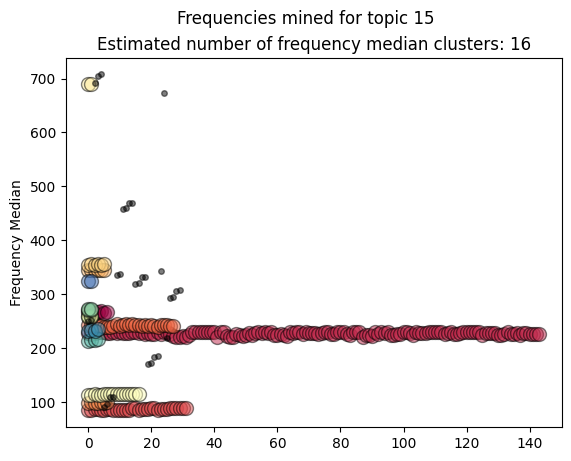

In [35]:
import matplotlib.pyplot as plt
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=10,
        alpha=0.5
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=4,
        alpha=0.5
    )

plt.title(f"Estimated number of frequency median clusters: {n_clusters}")
plt.ylabel('Frequency Median')
plt.suptitle(f"Frequencies mined for topic {inspect_topic}")
plt.show()

### Assign labels to measurements for topic and find cluster centers

In [36]:
selected_topic = pd.DataFrame(train_topic_freqs.loc[inspect_topic].med_freq, train_topic_freqs.loc[inspect_topic].diff_freq)\
    .reset_index()
selected_topic.columns = ['diff_freq', 'med_freq']
selected_topic['cluster_freq'] = labels
selected_topic.sort_values('med_freq', ascending=True).iloc[1450:1500]

,diff_freq,med_freq,cluster_freq


### Take mean of frequency median and difference by cluster to generate 'areas of interest'.
Using $mean(\text{median freq}) \pm \frac{mean(\text{frequency difference})}{2}$

In [37]:
topic_cluster = selected_topic.groupby('cluster_freq').mean()

Drop cluster id = -1 as this is noise

In [38]:
topic_cluster = topic_cluster.drop(-1, axis=0)

In [39]:
topic_cluster['lower_bound'] = topic_cluster.med_freq - (topic_cluster.diff_freq/2)
topic_cluster['upper_bound'] = topic_cluster.med_freq + (topic_cluster.diff_freq/2)
topic_cluster.sort_values('lower_bound', ascending=True)

,diff_freq,med_freq,lower_bound,upper_bound
cluster_freq,,,,
2,0.636563,86.672344,86.354062,86.990625
4,1.374286,98.440000,97.752857,99.127143
8,1.326471,114.373824,113.710588,115.037059
13,1.932500,215.161250,214.195000,216.127500
1,1.909028,227.382361,226.427847,228.336875
14,1.907500,233.211250,232.257500,234.165000
3,1.870357,241.991964,241.056786,242.927143
9,1.865000,257.612500,256.680000,258.545000
10,1.875000,259.447500,258.510000,260.385000


### Test topics in topic

In [40]:
test_max_topic = test_doc_topic.idxmax(axis=1).to_frame()
test_max_topic.columns = ['max_topic']
test_max_topic.query(f'max_topic == {inspect_topic}')

,max_topic
2018.1.00397.S,15
2022.1.01122.S,15
2022.1.01173.S,15
2021.1.00800.S,15
2015.1.00597.S,15
2015.1.00989.S,15
2021.1.00850.S,15
2019.2.00124.S,15
2013.1.00229.S,15
2016.1.01135.S,15


In [1365]:
sorted(test_proj_meas.loc[test_max_topic.query(f'max_topic == {inspect_topic}').index.values].med_freq.values)

[[114.755, 114.905, 114.515, 114.345, 114.71, 114.87, 114.7, 114.695],
 [220.42,
  222.125,
  234.69,
  218.885,
  220.585,
  233.065,
  222.265,
  223.97,
  236.655,
  218.995,
  220.695,
  233.18],
 [224.95,
  226.93,
  239.74,
  241.695,
  212.675,
  214.67,
  227.615,
  229.605,
  212.82,
  214.81,
  227.765,
  229.76],
 [226.81, 228.645, 240.955],
 [227.185, 241.375, 225.655, 239.735, 227.575, 241.78, 226.78, 240.945],
 [228.135, 228.48, 228.245, 228.8, 228.69],
 [228.865, 226.925, 226.935, 225.66, 225.025],
 [229.005, 231.005, 243.955, 246.505],
 [229.14, 227.7, 229.365, 228.405, 228.435],
 [229.76],
 [229.81, 230.115, 229.635],
 [229.82, 229.29, 230.015, 228.44, 226.4, 228.09, 228.42, 229.91],
 [230.575, 230.29],
 [243.005, 244.9, 258.195, 259.885],
 [271.485,
  115.065,
  115.06,
  345.17,
  356.08,
  265.4,
  267.07,
  88.47,
  89.025,
  90.495,
  97.805,
  109.585,
  110.0],
 [342.9, 344.5, 340.455, 342.025, 344.24, 345.845, 340.465, 342.035],
 [344.27, 346.075],
 [346.135, 3

### Check how many test measurement median frequencies fall within an area of interest generated by clustering

In [1366]:
# Add closest match frequency cluster!!!!!!!
test_project_index = 0
matches = 0
for freq in list(test_proj_meas.loc[test_max_topic.query(f'max_topic == {inspect_topic}').index.values].med_freq.values[test_project_index]):
    print(f'Testing frequency measurement {freq}')
    for cluster in topic_cluster.index.values:
        lower_bound = round(topic_cluster.iloc[cluster].lower_bound, 3)
        upper_bound = round(topic_cluster.iloc[cluster].upper_bound, 3)
        if ((freq >= lower_bound) and (freq <= upper_bound)):
            print(f'Test frequency measurement {freq} matches to cluster {cluster} range {lower_bound}-{upper_bound}')
            matches += 1
    num_measurements = len(list(test_proj_meas.loc[test_max_topic.query(f'max_topic == {inspect_topic}').index.values].med_freq.values[test_project_index]))
    print(f'Percent matches: {matches/num_measurements}')
    print('====================')

Testing frequency measurement 228.865
Percent matches: 0.0
Testing frequency measurement 226.925
Test frequency measurement 226.925 matches to cluster 1 range 226.428-228.337
Percent matches: 0.2
Testing frequency measurement 226.935
Test frequency measurement 226.935 matches to cluster 1 range 226.428-228.337
Percent matches: 0.4
Testing frequency measurement 225.66
Percent matches: 0.4
Testing frequency measurement 225.025
Percent matches: 0.4


### Loop over topics and find accuracy measurements

In [81]:
test_project_hits = 0       # Hits for all projects if at least one measurement is matched
test_project_meas_hit_rate = []     # List of hit rates by project
# Loop over topics
for tpc in params_frame.index:
    # DBSCAN with parameters from topic parameter data frame
    db = DBSCAN(eps=0.5, min_samples=2)\
        .fit(list(zip(train_topic_freqs.loc[tpc].med_freq)))
    # db = DBSCAN(eps=params_frame.loc[tpc].eps, min_samples=2)\
    # .fit(list(zip(train_topic_freqs.loc[tpc].med_freq)))
    
    # Get labels from DBSCAN
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_points = len(list(labels))
    n_noise = list(labels).count(-1)

    # Stat callouts
    print(f'DBSCAN Results for topic {tpc}')
    print(f'Estimated number of clusters: {n_clusters}')
    print(f'Total number of measurements: {n_points}')
    print(f'Estimated number of noise measurements: {n_noise}')
    print(f'Noise percentage: {round(list(labels).count(-1)/labels.shape[0], 3)}')
    print(f'Signal to noise ratio: {round(1-list(labels).count(-1)/labels.shape[0], 3)}')

    # Create data frame for measurements in this specific topic
    selected_topic = pd.DataFrame(train_topic_freqs.loc[tpc].med_freq,
                                  train_topic_freqs.loc[tpc].diff_freq)\
    .reset_index()
    selected_topic.columns = ['diff_freq', 'med_freq']
    selected_topic['cluster_freq'] = labels

    # Take mean of diff_freq and med_freq to generate areas of interest    
    topic_cluster = selected_topic.groupby('cluster_freq').mean()
    topic_cluster = topic_cluster.drop(-1, axis=0)  # Drop noise (label -1)
    topic_cluster['lower_bound'] = topic_cluster.med_freq - (topic_cluster.diff_freq/2)
    topic_cluster['upper_bound'] = topic_cluster.med_freq + (topic_cluster.diff_freq/2)
    topic_cluster.sort_values('lower_bound', ascending=True)

    # Get a list of test project codes
    tps = test_max_topic.query(f'max_topic == {tpc}')

    # Check to see if there are any test projects assigned to this topic
    # ADD IF, ELSE STATEMENT HERE, ATTACH ELSE TO FOLLOWING CODE

    #Begin test projects
    print('')
    print('Begin tests')

    # Loop over test projects
    for tp in tps.index:
        tp_hr = 0   # Hit rate for this specific project
        print(f'Test project {tp}:')
        # Loop over measurements in test project
        for meas in test_proj_meas.loc[tp].med_freq:
            # Loop over clusters in topic
            for clust in topic_cluster.index.values:
                lower_bound = round(topic_cluster.loc[clust].lower_bound, 3)
                upper_bound = round(topic_cluster.loc[clust].upper_bound, 3)
                if ((meas >= lower_bound) and (meas <= upper_bound)):
                    tp_hr += 1
                    test_project_meas_hit_rate.append(round(tp_hr/len(list(test_proj_meas.loc[tp].med_freq)), 3))

        #Print some stats
        print(f'Number of measurements: {len(test_proj_meas.loc[tp].med_freq)}')
        print(f'Hits: {tp_hr}')
        print(f'Hit rate: {round(tp_hr/len(list(test_proj_meas.loc[tp].med_freq)), 3)}')
        print('')

        # Increment test_project_hits if at least one measurement in the project matched
        if (tp_hr > 0):
            test_project_hits +=1
    print('=========================================\n')

print(f'Number of test projects with at least one measurement match: {test_project_hits}')
print(f'Ratio of test project hits to number of test projects: {test_project_hits/test_texts.shape[0]}')
#print(f'Average hit rate per project: {test_project_meas_hit_rate/test_texts.shape[0]}')

DBSCAN Results for topic 0
Estimated number of clusters: 48
Total number of measurements: 189
Estimated number of noise measurements: 26
Noise percentage: 0.138
Signal to noise ratio: 0.862

Begin tests
Test project 2017.1.00834.S:
Number of measurements: 4
Hits: 1
Hit rate: 0.25


DBSCAN Results for topic 1
Estimated number of clusters: 55
Total number of measurements: 270
Estimated number of noise measurements: 13
Noise percentage: 0.048
Signal to noise ratio: 0.952

Begin tests
Test project 2022.1.00236.S:
Number of measurements: 23
Hits: 17
Hit rate: 0.739

Test project 2023.1.01382.S:
Number of measurements: 12
Hits: 0
Hit rate: 0.0

Test project 2018.1.01559.S:
Number of measurements: 1
Hits: 2
Hit rate: 2.0

Test project 2023.1.00737.S:
Number of measurements: 14
Hits: 8
Hit rate: 0.571

Test project 2016.1.01217.S:
Number of measurements: 8
Hits: 4
Hit rate: 0.5

Test project 2013.1.01194.S:
Number of measurements: 15
Hits: 13
Hit rate: 0.867

Test project 2013.1.00527.S:
Numbe

In [ ]:
2018.1.01559.S